#  Прогнозирование колличества заказов такси.

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# 1. Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

# модель
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


# метрика
from sklearn.metrics import mean_squared_error
from IPython.display import display


In [2]:
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df_taxi.sort_index(inplace=True)

df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# проверка, что индекс монотонный
print('Данны расположены в хронологическом порядке:',df_taxi.index.is_monotonic)

# печать первых 5 строк
df_taxi.head(5)

Данны расположены в хронологическом порядке: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


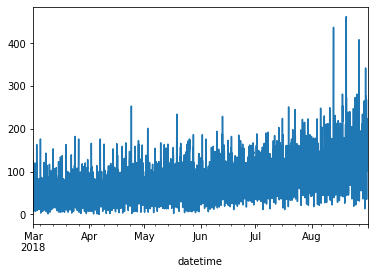

In [4]:
# группировка по часам
df_taxi = df_taxi.resample('1H').sum()
df_taxi['num_orders'].plot()

# 2. Анализ

In [5]:
data = df_taxi.resample('1D').sum()

decomposed = seasonal_decompose(data['num_orders'])

Text(0, 0.5, 'Значения ряда')

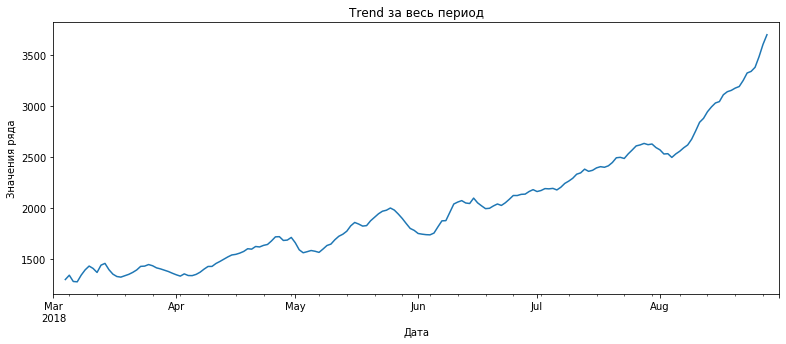

In [6]:
plt.figure(figsize=(13, 5))
plt.subplot(111)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend за весь период')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)


Данные представлены интервалом в 6 месяцев с марта по август 2018 г. Наблюдается положительно растущий тренд.


Text(0, 0.5, 'Значения ряда')

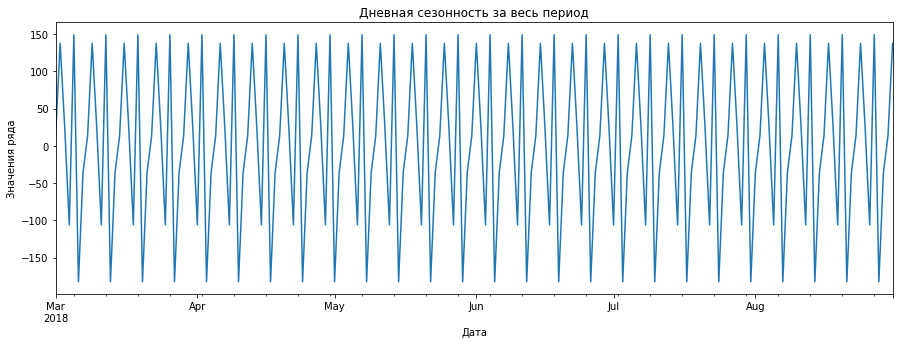

In [7]:
data = df_taxi.resample('1D').sum()

decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15, 5))
plt.subplot(111)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Дневная сезонность за весь период')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

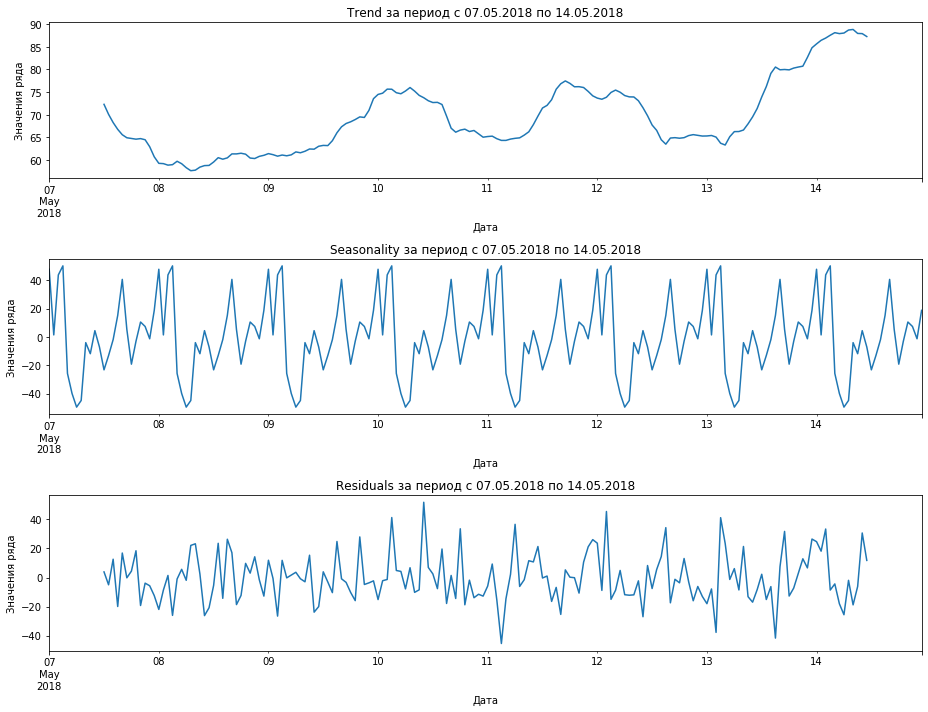

In [8]:
data = df_taxi['2018-05-7':'2018-05-14'].resample('1H').sum()

decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(13, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend за период с 07.05.2018 по 14.05.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality за период с 07.05.2018 по 14.05.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals за период с 07.05.2018 по 14.05.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.tight_layout()

Посмотрев на графики сразу видно положительно растущий тренд, что радует.
Также вижна ярковыраженная еженедельная сезонность, с пиком по середине недели и с воскресенья на понедельник.
Внутри дня рост спроса приобладает в вечсерние часы.

Создадим функцию для зоздания новых признаков, поскольку данные представлены 6 месяцм одного года, то добавим призанки месяц, день и день недели

In [9]:
# функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [65]:
make_features(df_taxi, 6, 7)

# посмотрим на таблицу с новыми признаками
df_taxi.head(10)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,66.0,71.0,85.0,58.142857
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,43.0,66.0,71.0,42.571429


# 3. Обучение

In [11]:
# разделение на 2 выборки (обучающая и валидационная)
df_train, df_valid = train_test_split(df_taxi, shuffle=False, test_size=0.1, random_state=12345)
# размер таблицы
print(df_taxi.shape)
print('Кол-во строк в обучающей выборке:', df_train.shape[0])
print('Кол-во строк в валидационной выборке:', df_valid.shape[0])

# добавил 3ю выборку для теста, того же размера, что и валидационная
df_test_size = df_valid.shape[0] / df_train.shape[0]
df_train, df_test = train_test_split(df_train, test_size=df_test_size, shuffle=False, random_state=12345)
print()
print('Кол-во строк в обучающей выборке:', df_train.shape[0])
print('Кол-во строк в валидационной выборке:', df_valid.shape[0])
print('Кол-во строк в тестовой выборке:', df_test.shape[0])

# удалим пропуски, которые получились при создание новых признаков
df_train = df_train.dropna()
df_valid = df_valid.dropna()
df_test = df_test.dropna()

# разделение на обучающие признаки и целевые
features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

features_valid = df_valid.drop(['num_orders'], axis=1)
target_valid = df_valid['num_orders']

features_test = df_test.drop(['num_orders'], axis=1)
target_test = df_test['num_orders']



(4416, 11)
Кол-во строк в обучающей выборке: 3974
Кол-во строк в валидационной выборке: 442

Кол-во строк в обучающей выборке: 3532
Кол-во строк в валидационной выборке: 442
Кол-во строк в тестовой выборке: 442


In [12]:
# разбиение на подвыборки для кросс-валидации
kf = KFold(n_splits=10, shuffle=False, random_state=12345)

# словарь для результатов тесторвания
test_score = {}

In [13]:
%%time
line_reg_model = LinearRegression().fit(features_train, target_train)

predictions = line_reg_model.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
rmse_train

predictions_valid = line_reg_model.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
    
predictions_test = line_reg_model.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_valid ** 0.5

print("rmse обучающей выборки:", rmse_train)
print("rmse валидационной выборки: ", rmse_valid)
print("rmse тестовой выборки: ", rmse_test)

rmse обучающей выборки: 29.02319675542125
rmse валидационной выборки:  53.704796029616716
rmse тестовой выборки:  53.704796029616716
CPU times: user 30 ms, sys: 27.2 ms, total: 57.2 ms
Wall time: 11.7 ms


In [14]:
test_score['LinearRegression'] = [rmse_train, rmse_valid, rmse_test]

In [15]:
for depth in np.arange(1, 10):
    regr = (DecisionTreeRegressor(max_depth=depth, random_state=12345)
        .fit(features_train, target_train)
       )
    predictions = regr.predict(features_train)
    mse = mean_squared_error(target_train, predictions)
    rmse = mse ** 0.5
    
    predictions_valid = regr.predict(features_valid)
    mse_valid = mean_squared_error(target_valid, predictions_valid)
    rmse_valid = mse_valid ** 0.5
    
    print("max_depth =", depth, ":")
    print("Результат проверки на обучающей  выборке", rmse)
    print("Результат проверки на валидационной выборке", rmse_valid)
    print()

max_depth = 1 :
Результат проверки на обучающей  выборке 31.869565852689988
Результат проверки на валидационной выборке 79.1725872122151

max_depth = 2 :
Результат проверки на обучающей  выборке 29.832572261311725
Результат проверки на валидационной выборке 72.72865770358361

max_depth = 3 :
Результат проверки на обучающей  выборке 29.134575358421532
Результат проверки на валидационной выборке 69.65260632793994

max_depth = 4 :
Результат проверки на обучающей  выборке 28.382704578183915
Результат проверки на валидационной выборке 75.62719606457016

max_depth = 5 :
Результат проверки на обучающей  выборке 27.58830533588969
Результат проверки на валидационной выборке 66.93555300577034

max_depth = 6 :
Результат проверки на обучающей  выборке 26.516552104552417
Результат проверки на валидационной выборке 68.39613622113804

max_depth = 7 :
Результат проверки на обучающей  выборке 25.295375456833437
Результат проверки на валидационной выборке 66.73619615714922

max_depth = 8 :
Результат про

In [16]:
for estim in np.arange(1, 50, 2):
    rf_regr = (RandomForestRegressor(max_depth=8, 
                                     n_estimators=estim,
                                     random_state=12345)
        .fit(features_train, target_train)
       )
    predictions = rf_regr.predict(features_train)
    mse = mean_squared_error(target_train, predictions)
    rmse = mse ** 0.5
    
    predictions_valid = rf_regr.predict(features_valid)
    mse_valid = mean_squared_error(target_valid, predictions_valid)
    rmse_valid = mse_valid ** 0.5
    
    print("n_estimators =", estim, ":")
    print("Результат проверки на обучающей  выборке", rmse)
    print("Результат проверки на валидационной выборке", rmse_valid)
    print()

n_estimators = 1 :
Результат проверки на обучающей  выборке 26.2634557195304
Результат проверки на валидационной выборке 81.00267282647731

n_estimators = 3 :
Результат проверки на обучающей  выборке 23.311262108882165
Результат проверки на валидационной выборке 70.29680594415872

n_estimators = 5 :
Результат проверки на обучающей  выборке 22.899794960162787
Результат проверки на валидационной выборке 67.23158089518438

n_estimators = 7 :
Результат проверки на обучающей  выборке 22.749400089292166
Результат проверки на валидационной выборке 67.18280231094022

n_estimators = 9 :
Результат проверки на обучающей  выборке 22.592387080127846
Результат проверки на валидационной выборке 66.85641369470568

n_estimators = 11 :
Результат проверки на обучающей  выборке 22.576615753461482
Результат проверки на валидационной выборке 66.87371752559314

n_estimators = 13 :
Результат проверки на обучающей  выборке 22.52003108610775
Результат проверки на валидационной выборке 66.02417468714556

n_estim

In [17]:
%%time
# 
cbr = CatBoostRegressor(iterations=300,  
                        random_state=12345,  
                        loss_function='RMSE')
cbr.fit(features_train, target_train,  verbose=30)
predictions = cbr.predict(features_train)

mse = mean_squared_error(target_train, predictions)
rmse = mse ** 0.5
rmse

predictions_valid = rf_regr.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

predictions_test = rf_regr.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test
   
print("Результат проверки на обучающей  выборке", rmse)
print("Результат проверки на валидационной выборке", rmse_valid)
print("Результат проверки на тестовой выборке", rmse_test)
print()

0:	learn: 35.3794228	total: 49.8ms	remaining: 14.9s
30:	learn: 29.8693978	total: 455ms	remaining: 3.94s
60:	learn: 28.0027772	total: 1.04s	remaining: 4.06s
90:	learn: 27.1263831	total: 1.53s	remaining: 3.51s
120:	learn: 26.5407458	total: 2.11s	remaining: 3.13s
150:	learn: 26.0969160	total: 2.61s	remaining: 2.57s
180:	learn: 25.7158738	total: 3.19s	remaining: 2.1s
210:	learn: 25.3884933	total: 3.68s	remaining: 1.55s
240:	learn: 25.0650995	total: 4.26s	remaining: 1.04s
270:	learn: 24.7645061	total: 4.76s	remaining: 509ms
299:	learn: 24.4515555	total: 5.26s	remaining: 0us
Результат проверки на обучающей  выборке 24.451555491438707
Результат проверки на валидационной выборке 65.13636024671084
Результат проверки на тестовой выборке 42.036783073675586

CPU times: user 4.9 s, sys: 624 ms, total: 5.52 s
Wall time: 9.06 s


In [18]:
test_score['CatBoostRegressor'] = [rmse_train, rmse_valid, rmse_test]

In [19]:
%%time
parameters = {'max_depth': np.arange(5, 10),
              'n_estimators': np.arange(10, 20)
             }

gs = GridSearchCV(LGBMRegressor(random_state=12345), 
                  parameters,
                  cv=kf,
                  scoring='neg_mean_squared_error')

# обучение
gs.fit(features_train, target_train)
# просмотр лучших параметров
gs.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 2min 1s, sys: 1.51 s, total: 2min 3s
Wall time: 2min 4s


{'max_depth': 7, 'n_estimators': 19}

In [20]:
# лучший результат
gs.best_score_

-801.4636059754022

# 4. Тестирование

In [21]:
%%time
regr = (DecisionTreeRegressor(max_depth=7, random_state=12345)
        .fit(features_train, target_train)
       )

predictions = regr.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse = mse ** 0.5
    
predictions_valid = regr.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

predictions_test = regr.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5

CPU times: user 22.1 ms, sys: 25 µs, total: 22.2 ms
Wall time: 21.2 ms


In [22]:
test_score['DecisionTreeRegressor'] = [rmse_train, rmse_valid, rmse_test]

In [23]:
%%time
rf_regr = (RandomForestRegressor(max_depth=8,
                                 n_estimators=19,
                                 random_state=12345
                                )
           .fit(features_train, target_train)
          )
predictions = rf_regr.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = rf_regr.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

predictions_test = rf_regr.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

CPU times: user 258 ms, sys: 0 ns, total: 258 ms
Wall time: 271 ms


42.16466520028622

In [24]:
test_score['RandomForestRegressor'] = [rmse_train, rmse_valid, rmse_test]

In [25]:
%%time
model_lgb = (LGBMRegressor(max_depth=7, 
                           n_estimators=19
                           )
             .fit(features_train, target_train)
            )

predictions = model_lgb.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5

predictions_valid = model_lgb.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

predictions_test = model_lgb.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

CPU times: user 382 ms, sys: 157 µs, total: 382 ms
Wall time: 383 ms


43.225522078547435

In [26]:
test_score['LGBMRegressor'] = [rmse_train, rmse_valid, rmse_test]

In [27]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['RMSE train', 'RMSE valid', 'RMSE test'], orient='index')
df_score

,RMSE train,RMSE valid,RMSE test
LinearRegression,29.023197,53.704796,53.704796
CatBoostRegressor,29.023197,65.136360,42.036783
DecisionTreeRegressor,29.023197,66.736196,44.666433
RandomForestRegressor,22.309929,66.399570,42.164665
LGBMRegressor,24.917416,69.897460,43.225522


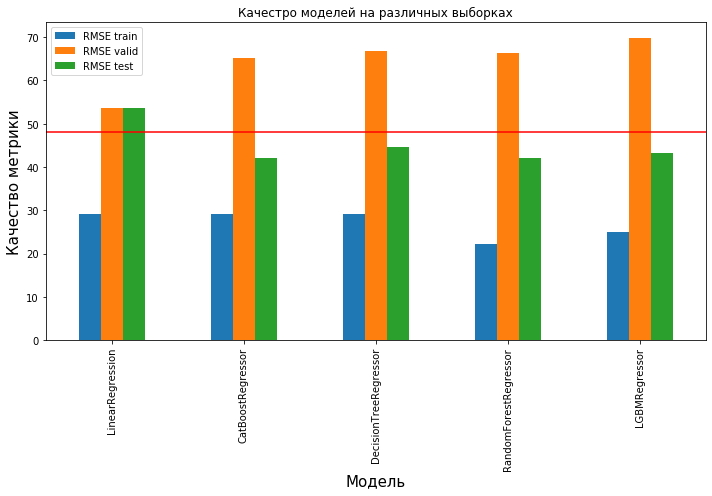

In [28]:
plt.figure(figsize=(10, 7))
plt.subplot(111)
df_score.plot(kind='bar', ax=plt.gca()).hlines(48, -1, 5,
                                              color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Качество метрики', fontsize=15)
plt.title('Качестро моделей на различных выборках')

plt.tight_layout()

----
### Выводы:
<br />
Несколько моделей показываются заданное качество на тестовой выборке, при этом наилучшее качество показывает CatBoostRegressor.


----

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48